# The Alphafold Evoformer

Oh man this was my goal from the start. And now I think I have a grasp of the architecture well enough to try it myself. This evoformer is from alphafold 2. If I can do this, maybe I'll try my hand at the alphafold 3 pairformer and diffusion model.

## some stuff about the inputs

There is a lot of parsing and preparation in the actual project. But to skip ahead, alphafold 2 is built from 3 parts:

MSA Representation
The initial sequence is checked against a genetic database search to find similar sequences that lead to similar proteins. Due to the random nature of mutations, these differences between the protein in different species should have random differences, but evolutionary pressure causes all the sequences, which are slightly different, to end with a simlar structure. A strategy of Alphafold 2 is to look at this evolutionary history and analyze residues that may have coevolved and infer the importance of such residue for the actual structure. This raw data of the sequences is called the multiple sequence alignment, or MSA. The MSA representation is a matrix of size (number of sequences, number of residues, embedding channels for each residue). Importantly, if we analyze the matrix row-wise, we are studying the effect of residues on eachother on the same sequence. If we analyze the matrix column wise, we are witnessing the evolutionary history/context of that residue. The independence of these information sources kind of allow us to apply attention to each independently and drastically reduce the attention context size to a reasonable level.

Pair Representation
A square matrix with size (number of residues) squared serves as a template for the pair representation matrix, where an entry i,j indicates the interaction between two residues. The initialization is the addition of two things:
- Concatenated one hot encodings: Each residue is given a one hot encoding and the two vectors in the pair are added for the i,j entry.
- Relative positional embeddings: A vector that encodes the separation between residue i and j in the chain. This vector is not a simple integer encoding the difference in residues but rather a a set of sinusoidal functions of different frequencies (like how positional embeddings are done in nlp)
The resulting vector length becomes the third matrix dimension that represents the embedding dimension of each residue pair.

In the alphafold 2 paper, the length of the embedded information of a residue or residue pair is described as the channel dimension. Personally, I prefer the sound of embedding dimension, but it doesn't matter mathematically. I believe the reason for Deepmind's wordchoice is because of this projects reliance on 2D matrix data as opposed to the nlp 1D data.

In [47]:
from flax import nnx
import jax
from jax import random
import jax.numpy as jnp
import math
from typing import Optional

In [48]:
class GatedMHA(nnx.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        head_dim: int,
        *,
        bias_channels: Optional[int] = None,
        rngs: nnx.Rngs,
    ):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.attention_dim = self.num_heads * self.head_dim

        self.layer_norm_m = nnx.LayerNorm(num_features=embed_dim, rngs=rngs)
        self.qkv_proj = nnx.Linear(
            in_features=embed_dim,
            out_features=self.attention_dim * 3,
            use_bias=False,
            rngs=rngs,
        )
        self.gate_proj = nnx.Linear(
            in_features=embed_dim,
            out_features=self.attention_dim,
            rngs=rngs,
        )
        self.output_proj = nnx.Linear(
            in_features=self.attention_dim,
            out_features=embed_dim,
            rngs=rngs,
        )

        if bias_channels is not None:
            self.layer_norm_z = nnx.LayerNorm(num_features=bias_channels, rngs=rngs)
            self.pair_bias_proj = nnx.Linear(
                in_features=bias_channels,
                out_features=num_heads,
                use_bias=False,
                rngs=rngs,
            )
        else:
            self.layer_norm_z = None
            self.pair_bias_proj = None

    def __call__(
        self,
        m: jax.Array,
        z: Optional[jax.Array] = None,
        mask: Optional[jax.Array] = None
    ) -> jax.Array:
        seq_len, _ = m.shape

        gate_values = self.gate_proj(m)
        gate_values = gate_values.reshape(seq_len, self.num_heads, self.head_dim)
        # gate: (num_heads, seq_len, head_dim)
        gate = nnx.sigmoid(jnp.transpose(gate_values, (1, 0, 2)))

        m_norm = self.layer_norm_m(m)
        qkv = self.qkv_proj(m_norm)
        qkv = qkv.reshape(seq_len, 3, self.num_heads, self.head_dim)
        qkv = jnp.transpose(qkv, (1, 2, 0, 3))
        q, k, v = qkv[0], qkv[1], qkv[2] # (num_heads, seq_len, head_dim)

        attention_logits = jnp.einsum("hid,hjd->hij", q, k)
        attention_logits /= math.sqrt(self.head_dim)

        if z is not None: # (seq_len, seq_len, bias_channels)
            z_norm = self.layer_norm_z(z)
            pair_bias = self.pair_bias_proj(z_norm) # (seq_len, seq_len, num_heads)
            pair_bias = jnp.transpose(pair_bias, (2, 0, 1)) # (num_heads, seq_len, seq_len)
            attention_logits += pair_bias

        if mask is not None:
            attention_mask = nnx.make_attention_mask(mask, mask)
            attention_logits += jnp.where(attention_mask, 0.0, -1e9)

        weights = nnx.softmax(attention_logits, axis=-1)

        attn_output = jnp.einsum("hij,hjd->hid", weights, v) #(num_heads, seq_len, head_dim)
        gated_attn_output = attn_output * gate

        gated_attn_output = jnp.transpose(gated_attn_output, (1, 0, 2)) #(seq_len, num_heads, head_dim)
        concatenated_output = gated_attn_output.reshape(seq_len, self.attention_dim) # (seq_len, attention_dim)
        final_output = self.output_proj(concatenated_output)

        return final_output

In [49]:
msa_channels = 384
msa_num_heads = 8
msa_head_dim = 32
pair_channels = 128

key = jax.random.PRNGKey(0)
dropout_key = jax.random.PRNGKey(1)
rngs = nnx.Rngs(params=key, dropout=dropout_key)

# attention over residues
class MSARowAttentionWithPairBias(nnx.Module):
    def __init__(self, msa_channels, pair_channels, *, num_heads=8, head_dim=32,rngs: nnx.Rngs):
        self.gated_mha = GatedMHA(
            embed_dim=msa_channels, 
            num_heads=num_heads, 
            head_dim=head_dim,
            bias_channels=pair_channels,
            rngs=rngs
        )
        self.vmapped_mha = nnx.vmap(
            self.gated_mha,
            in_axes=(0,None),
            out_axes=0,
        )
    
    def __call__(self, msa: jax.Array, z: jax.Array) -> jax.Array:
        return self.vmapped_mha(msa,z)

# attention across sequences
class MSAColumnAttention(nnx.Module):
    def __init__(self, msa_channels, num_heads=8, head_dim=32, *, rngs: nnx.Rngs):
        self.gated_mha = GatedMHA(
            embed_dim=msa_channels, 
            num_heads=num_heads, 
            head_dim=head_dim,
            bias_channels=None,
            rngs=rngs
        )
        self.vmapped_mha = nnx.vmap(
            self.gated_mha,
            in_axes=1,
            out_axes=1,
        )
    
    def __call__(self, msa: jax.Array) -> jax.Array:
        return self.vmapped_mha(msa)

# transition
class MSATransition(nnx.Module):
    def __init__(self, msa_channels, *, rngs: nnx.Rngs, n=4):
        self.layer_norm = nnx.LayerNorm(num_features=msa_channels, rngs=rngs)
        self.linear1 = nnx.Linear(msa_channels, n*msa_channels, rngs=rngs)
        self.linear2 = nnx.Linear(n*msa_channels, msa_channels, rngs=rngs)
    
    def __call__(self, msa: jax.Array) -> jax.Array:
        msa_norm = self.layer_norm(msa)
        output = self.linear1(msa_norm)
        output = self.linear2(nnx.relu(output))
        return output

class OuterProductMean(nnx.Module):
    def __init__(self, msa_channels, *, rngs: nnx.Rngs, pair_channels, c=32):
        self.layer_norm = nnx.LayerNorm(num_features=msa_channels, rngs=rngs)
        self.linear_a = nnx.Linear(msa_channels, c, rngs=rngs)
        self.linear_b = nnx.Linear(msa_channels, c, rngs=rngs)
        self.linear_out = nnx.Linear(c ** 2, pair_channels, rngs=rngs)
    
    def __call__(self, msa: jax.Array) -> jax.Array:
        msa_norm = self.layer_norm(msa)
        a,b = self.linear_a(msa_norm), self.linear_b(msa_norm)
        outer_product = jnp.einsum('sic,sjd->sijcd', a, b)
        mean_outer_product = jnp.mean(outer_product, axis=0)
        o = mean_outer_product.reshape(*mean_outer_product.shape[:-2], -1)
        z = self.linear_out(o)
        return z

class TriangleUpdateOutgoing(nnx.Module):
    def __init__(self, pair_channels: int, *, rngs: nnx.Rngs, c: int = 128):
        self.layer_norm_in = nnx.LayerNorm(num_features=pair_channels, rngs=rngs)
        self.linear_a_gate = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_a_val = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_b_gate = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_b_val = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_g = nnx.Linear(pair_channels, pair_channels, rngs=rngs)
        self.layer_norm_out = nnx.LayerNorm(num_features=c, rngs=rngs)
        self.linear_out = nnx.Linear(c, pair_channels, rngs=rngs)

    def __call__(self, z: jax.Array) -> jax.Array:
        normed_pairs = self.layer_norm_in(z)
        gate_a = nnx.sigmoid(self.linear_a_gate(normed_pairs))
        a = gate_a * self.linear_a_val(normed_pairs)
        gate_b = nnx.sigmoid(self.linear_b_gate(normed_pairs))
        b = gate_b * self.linear_b_val(normed_pairs)
        g = nnx.sigmoid(self.linear_g(normed_pairs))
        o = jnp.einsum('...ikc,...jkc->...ijc', a, b)
        o_norm = self.layer_norm_out(o)
        z_delta = g * self.linear_out(o_norm)
        return z_delta

class TriangleUpdateIncoming(nnx.Module):
    def __init__(self, pair_channels: int, *, rngs: nnx.Rngs, c: int = 128):
        self.layer_norm_in = nnx.LayerNorm(num_features=pair_channels, rngs=rngs)
        self.linear_a_gate = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_a_val = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_b_gate = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_b_val = nnx.Linear(pair_channels, c, rngs=rngs)
        self.linear_g = nnx.Linear(pair_channels, pair_channels, rngs=rngs)
        self.layer_norm_out = nnx.LayerNorm(num_features=c, rngs=rngs)
        self.linear_out = nnx.Linear(c, pair_channels, rngs=rngs)

    def __call__(self, z: jax.Array) -> jax.Array:
        normed_pairs = self.layer_norm_in(z)
        gate_a = nnx.sigmoid(self.linear_a_gate(normed_pairs))
        a = gate_a * self.linear_a_val(normed_pairs)
        gate_b = nnx.sigmoid(self.linear_b_gate(normed_pairs))
        b = gate_b * self.linear_b_val(normed_pairs)
        g = nnx.sigmoid(self.linear_g(normed_pairs))
        o = jnp.einsum('...kic,...kjc->...ijc', a, b)
        o_norm = self.layer_norm_out(o)
        z_delta = g * self.linear_out(o_norm)
        return z_delta
    

class TriangleAttentionStart(nnx.Module):
    def __init__(self, pair_channels, *, num_heads=8, head_dim=32,rngs: nnx.Rngs):
        self.gated_mha = GatedMHA(
            embed_dim=pair_channels, 
            num_heads=num_heads, 
            head_dim=head_dim,
            bias_channels=pair_channels,
            rngs=rngs
        )
        self.vmapped_mha = nnx.vmap(
            self.gated_mha,
            in_axes=(0,None),
            out_axes=0,
        )
    
    def __call__(self, z: jax.Array) -> jax.Array:
        return self.vmapped_mha(z,z)

class TriangleAttentionEnd(nnx.Module):
    def __init__(self, pair_channels, num_heads=8, head_dim=32, *, rngs: nnx.Rngs):
        self.gated_mha = GatedMHA(
            embed_dim=pair_channels, 
            num_heads=num_heads, 
            head_dim=head_dim,
            bias_channels=pair_channels,
            rngs=rngs
        )
        self.vmapped_mha = nnx.vmap(
            self.gated_mha,
            in_axes=(1,None),
            out_axes=1,
        )
    
    def __call__(self, z: jax.Array) -> jax.Array:
        return self.vmapped_mha(z,z)

class PairsTransition(nnx.Module):
    def __init__(self, pair_channels: int, *, rngs: nnx.Rngs, n: int = 4):
        self.layer_norm = nnx.LayerNorm(num_features=pair_channels, rngs=rngs)
        self.linear1 = nnx.Linear(pair_channels, n*pair_channels, rngs=rngs)
        self.linear2 = nnx.Linear(n*pair_channels, pair_channels, rngs=rngs)

    def __call__(self, z: jax.Array) -> jax.Array:
        normed_z = self.layer_norm(z)
        a = self.linear1(normed_z)
        output = self.linear2(nnx.relu(a))
        return output

In [50]:
class EvoformerBlock(nnx.Module):
    def __init__(self, msa_channels: int, pair_channels: int, *, rngs: nnx.Rngs):
        self.msa_channels = msa_channels
        self.pair_channels = pair_channels
        self.row_wise_gated_self_attention_with_pair_bias = MSARowAttentionWithPairBias(
            msa_channels=self.msa_channels,
            pair_channels=self.pair_channels,
            rngs=rngs
        )
        self.column_wise_gated_self_attention = MSAColumnAttention(
            msa_channels=self.msa_channels,
            rngs=rngs,
        )
        self.msa_transition = MSATransition(
            msa_channels=self.msa_channels,
            rngs=rngs,
        )
        self.outer_product_mean = OuterProductMean(
            msa_channels=self.msa_channels,
            pair_channels=self.pair_channels,
            rngs=rngs
        )
        self.triangular_update_outgoing_edges = TriangleUpdateOutgoing(
            pair_channels=self.pair_channels,
            rngs=rngs
        )
        self.triangular_update_incoming_edges = TriangleUpdateIncoming(
            pair_channels=self.pair_channels,
            rngs=rngs
        )
        self.triangle_self_attention_starting_node = TriangleAttentionStart(
            pair_channels=self.pair_channels,
            rngs=rngs
        )
        self.triangle_self_attention_ending_node = TriangleAttentionEnd(
            pair_channels=self.pair_channels,
            rngs=rngs
        )
        self.pairs_transition = PairsTransition(
            pair_channels=self.pair_channels,
            rngs=rngs
        )

    def __call__(self, msa: jax.Array, pairs: jax.Array) -> jax.Array:
        m_residue = self.row_wise_gated_self_attention_with_pair_bias(msa, pairs)
        m = msa + m_residue
        m += self.column_wise_gated_self_attention(m)
        new_msa = m + self.msa_transition(m)
        
        msa_updates = self.outer_product_mean(msa)
        p = pairs + msa_updates
        p += self.triangular_update_outgoing_edges(p)
        p += self.triangular_update_incoming_edges(p)
        p += self.triangle_self_attention_starting_node(p)
        p += self.triangle_self_attention_ending_node(p)
        new_pairs = p + self.pairs_transition(p)
        
        return new_msa, new_pairs


In [51]:
num_res = 100
num_sequences = 50
c_msa = 32
c_z = 30
batch_size = 64

rngs = nnx.Rngs(params=0, dropout=random.key(1))

single_msa = jnp.ones((num_sequences, num_res, c_msa))
single_pairs = jnp.ones((num_res, num_res, c_z))

evoformer = EvoformerBlock(
    msa_channels=c_msa,
    pair_channels=c_z,
    rngs=rngs,
)

msa, pairs = evoformer(single_msa,single_pairs)

In [52]:

msa = jnp.ones((batch_size,num_sequences, num_res, c_msa))
pairs = jnp.ones((batch_size,num_res, num_res, c_z))

batched_evoformer = nnx.vmap(evoformer, in_axes=0, out_axes=0)
msa, pairs = evoformer(single_msa,single_pairs)

## Takeaways

I really enjoyed three things about this projects:
1. This was my goal from the start. The evoformer was my naive "shoot for the moon" project to prove to myself that I understand neural network architectures. And finishing this is extremely fulfilling.
2. Thinking about the motivations and meanings of these mathematical operations has become a fun side hobby. For instance, the stated motivation for axial attention is to reduce the context window space, but when you go past that understanding, you also find Google Deepmind modelled the direction of their attention mechanisms with some real meaning. The row wise attention is used to analyze individual sequences or the outgoing edges of a triangle. The column wise attention analyzes the same residue target across sequences or the incoming edges of a triangle. It's beautifully cohesive
3. After sifting through jax, keras, and pytorch, I think flax/jax has the most beautiful abstractions. I hated the pytorch implementations of always being careful about batch size dimensions or hardware, and in jax, those things just work. With a few restrictions on how I write my functions (that pretty much all go away when you use nnx), vmap being able to indendently scale across a new dimension, letting me forget about batch size until the last moment. This was also really helpful when I was trying to apply attention row and column wise. vmap made it super easy to implement once I actually understood the system. Oh, and of course jit. I absolutely despise pytorch's to(device) abstraction. I'm not an expert by any means but I feel like it oversimplifies hardware while making code more complex. Wheras @jit just works. I heard pytorch is going towards a more compiler centric route, but until that happens and the research community makes mathematical expressions more idiomatic, I want to stick with jax.

As far as anything I want to improve or learn from still, there is one thing I found suprising about the triangular attention: it feels rudimentary. I thought there would be some crazy masking kungfu like we did with the causal masks in the transformer to enforce physical or logical rules. Like there would be a clever trick to mathematically enforce the triangle inequality (I heard alot about that particularly). However, this doesn't happen. The model is supposed to learn those rules for itself. Furthermore, the 'triangle' edges in the attention layer doesn't really seem to be stiched together in a clever way. One of the edges is simply used for the query, one is used for the key, and the last one is just thrown in there as a bias. I recognize that thinking semantically about architecture can be a trap, but I can't help but wonder why the key derived from the edge jk would do a good job attending to an query derived from ij, and how simply addking ki would close that gap. Would the neural network would have learned better connections with the triangular updates if the query was made from the edge ij, and the key was made from combining the edges jk and ki? I highly doubt that Google Deepmind missed this, and the latter approach is likely worse. But if I found out the 'why' of their architecture when they were drafting it, I feel like that would push me towards the next level of AI understanding past this bootcamp.

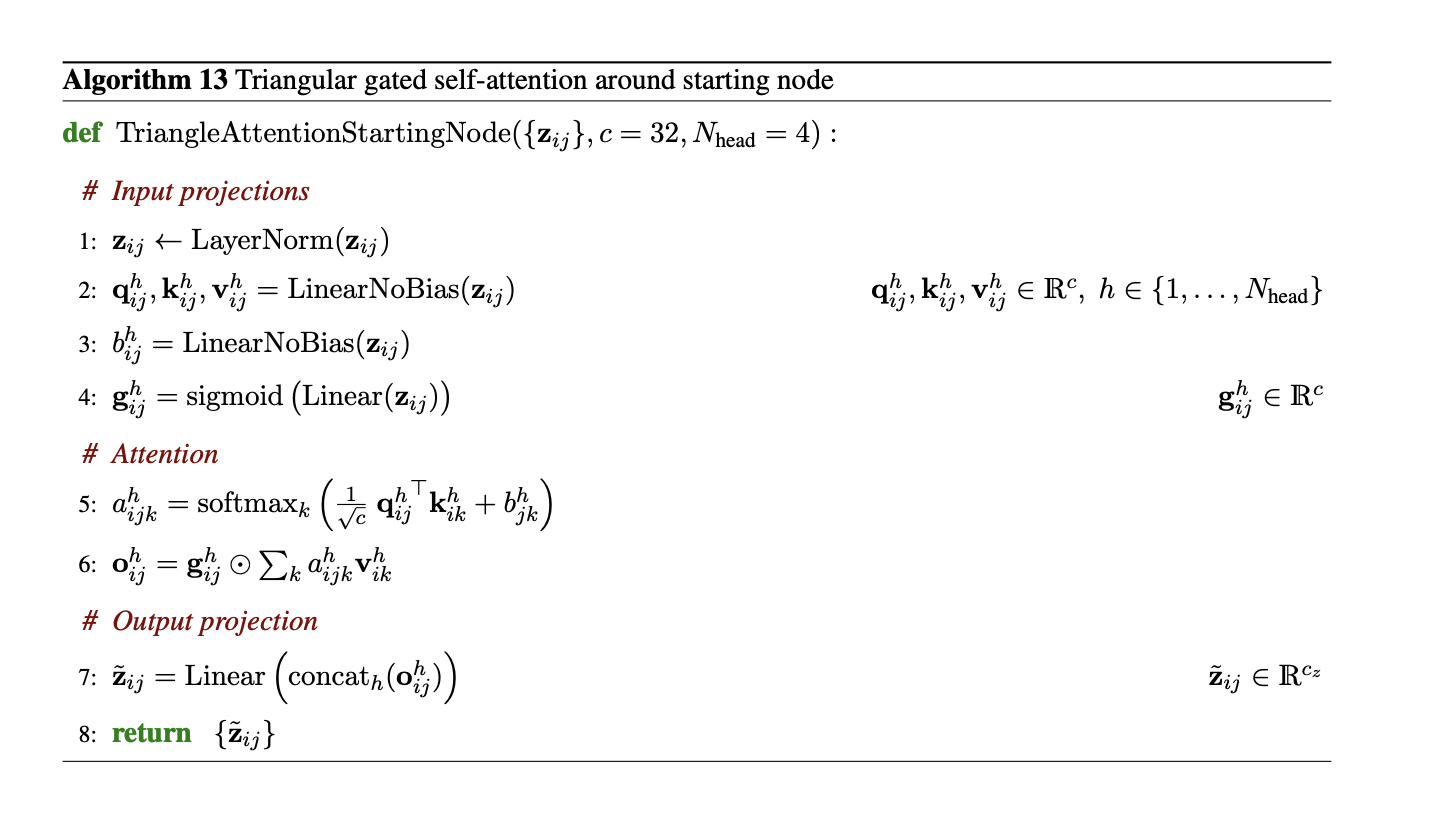